In [18]:
import os
# from netCDF4 import Dataset
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import pandas as pd
import datetime
# import pandas as pd
import xarray as xr
import seaborn
from scipy import signal

# fileLocation = '/Users/tennismichel/Coding/Python/DLR_LIDAR/Data'
fileLocation = '../Data'
fileName = "20191015-0014_T15Z900.nc"
path = os.path.join(fileLocation, fileName)

In [26]:
DS = xr.open_dataset(path, decode_times=False)
# attrs = {'units': 'seconds since 2019-10-15 00:00:00'}
# ds = xr.Dataset({'time': ('time', DS.time, attrs)})
DS.time.values = DS.time.values / 1000
DS.integration_start_time.values = DS.integration_start_time.values / 1000
DS.integration_end_time.values = DS.integration_end_time.values / 1000
DS.time.attrs['units'] = 'seconds since 2019-10-15'
DS.integration_start_time.attrs['units'] = 'seconds since 2019-10-15 00:00:00'
DS.integration_end_time.attrs['units'] = 'seconds since 2019-10-15 00:00:00'
DS = xr.decode_cf(DS, decode_coords = True, decode_times = True) 
# drop_variables = ['integration_start_time', 'integration_end_time'])

## Altitude ## 
DS['alt_plot'] = DS.altitude/1000 + DS.altitude_offset + DS.station_height #km

## Temperature ## 
# Change 0 to NaN
DS.temperature.values = np.where(DS.temperature == 0, np.nan, DS.temperature)
DS.temperature_err.values = np.where(DS.temperature_err == 0, np.nan, DS.temperature_err)
da_tmp = DS.temperature.dropna(dim='time', how="all")
da_tmp_err = DS.temperature_err.dropna(dim='time', how="all")
ds_tmp = da_tmp.to_dataset()
ds_tmp['temperature_err'] = da_tmp_err

date = datetime.datetime.strptime(DS.date_data_start, '%b %d %H:%M:%S %Y')
date

55

In [149]:
def butter_lowpass(highcut, fs, order=5):
    nyq = 0.5 * fs
    high_crit = highcut / nyq
    # print(high_crit)
    b, a = signal.butter(order, high_crit, btype='lowpass', analog=False)
    return b, a

def butterworthf(ds_tmp, highcut=1/5, fs=1/0.1, order=5, single_column_filter=True):
    """butterworth filter applied to matrix or each column seperately
        - uses the signal.butter and signal.lfilter functions of the SCIPY library
        - applies a low pass filter based on the given order and highcut frequency
    Input:
        - ds_tmp (xarray dataset that includes)
        - highcut frequency (1/wavelength) 5 work good 20km?
        - fs (sampling frequency) -> 100m 
        - order of filter = 5
    Output:
        - ds_tmp, which now includes the filtered temperature background and the perturbation
    """
    
    b, a = butter_lowpass(highcut, fs, order=order) 
    # print(b,a)
    # print("filter stable!", np.all(np.abs(np.roots(a))<1))

    if single_column_filter:
        # filter each column (returns matrix with Nans at bottom and top)
        columns_bg = np.full(ds_tmp.temperature.values.shape, np.NaN)
        for col, column in enumerate(ds_tmp.temperature):
            mask = np.isnan(column) # dataarray
            c_masked = column[~mask] # dataarray
            c_mirrored = np.append(np.flip(c_masked, axis=0), c_masked, axis=0) # numpy array
            c_filtered = signal.lfilter(b,a,c_mirrored, axis=0) # check axis
            c_filtered = c_filtered[len(c_masked):]
            column_bg = column.copy()
            column_bg[~mask] = c_filtered
            columns_bg[col,:] = column_bg
        ds_tmp['tmp_bg'] = (['time', 'altitude'], columns_bg)
    else:    
        # filter as matrix (some data is lost at the upper boundary)
        da_tmp = ds_tmp.temperature.dropna(dim='altitude', how="any")
        ds_tmp_2 = da_tmp.to_dataset()
        #ds_tmp['tmp_bg'] = ds_tmp.temperature
        tmp_mirrored = np.append(np.flip(ds_tmp_2.temperature, axis=1), ds_tmp_2.temperature, axis=1)
        tmp_filtered = signal.lfilter(b,a,tmp_mirrored, axis=1)
        tmp_filtered = tmp_filtered[:,len(da_tmp[0]):]
        ds_tmp_2['tmp_bg'] = (['time', 'altitude'], tmp_filtered)
        ds_tmp['tmp_bg'] = ds_tmp_2['tmp_bg']

    ds_tmp['tmp_pert'] = ds_tmp.temperature - ds_tmp.tmp_bg
    return ds_tmp

# print(np.shares_memory(c_masked, column))

da_tmp = DS.temperature.dropna(dim='time', how="all")

ds_tmp = da_tmp.to_dataset()
ds_tmp = butterworthf(ds_tmp)

<xarray.Dataset>
Dimensions:      (altitude: 1600, time: 95)
Coordinates:
  * time         (time) datetime64[ns] 2019-10-15T00:42:55 ... 2019-10-15T08:32:55
  * altitude     (altitude) uint32 0 100 200 300 ... 159600 159700 159800 159900
Data variables:
    temperature  (time, altitude) float32 nan nan nan nan ... nan nan nan nan
<xarray.Dataset>
Dimensions:      (altitude: 1600, time: 95)
Coordinates:
  * time         (time) datetime64[ns] 2019-10-15T00:42:55 ... 2019-10-15T08:32:55
  * altitude     (altitude) uint32 0 100 200 300 ... 159600 159700 159800 159900
Data variables:
    temperature  (time, altitude) float32 nan nan nan nan ... nan nan nan nan
    tmp_bg       (time, altitude) float64 nan nan nan nan ... nan nan nan nan
    tmp_pert     (time, altitude) float64 nan nan nan nan ... nan nan nan nan


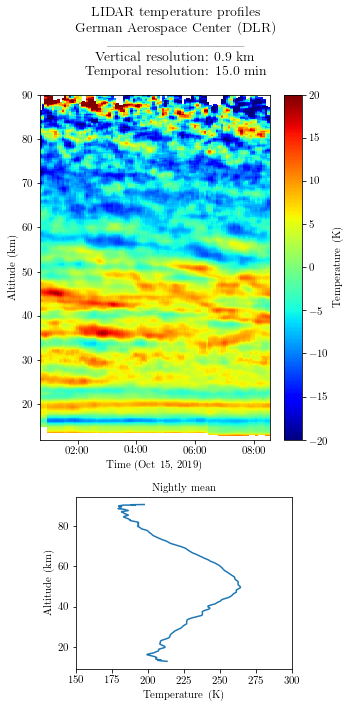

In [153]:
use_tex = 1 
if use_tex:
    ### Set tex font
    plt.rc('font',**{'family':'serif','serif':['Computer Modern Roman']})
    plt.rc('text', usetex=True)

    # Set font size
    SMALL_SIZE = 10.95
    MEDIUM_SIZE = 10.95
    plt.rc('font', size=MEDIUM_SIZE)         # controls default text sizes
    plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
    plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
    plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
    plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
    plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
    plt.rc('figure', titlesize=MEDIUM_SIZE)  # fontsize of the figure title
    ###

ds_tmp['alt_plot'] = ds_tmp.altitude/1000 + DS.altitude_offset + DS.station_height #km

fig, (ax0, ax1) = plt.subplots(nrows=2, figsize=(5,10), gridspec_kw={'height_ratios': [2, 1]})
im_temp = ax0.pcolormesh(ds_tmp.time.values, ds_tmp.alt_plot.values, np.matrix.transpose(ds_tmp.tmp_pert.values),
                         cmap='jet', vmin= -20, vmax = 20)
ax0.set_ylim(12,90)

# Labels
cbar = fig.colorbar(im_temp, ax=ax0)
cbar.set_label('Temperature (K)')
ax0.set_xlabel('Time ({})'.format(datetime.datetime.strftime(date, '%b %d, %Y')))
ax0.set_ylabel('Altitude (km)')

# X-Ticks
# if day > daybefore show date in new line
h_fmt = mdates.DateFormatter('%H:%M')
h_interv = mdates.HourLocator(interval = 2)
ax0.xaxis.set_major_locator(h_interv)
ax0.xaxis.set_major_formatter(h_fmt)

#fig.autofmt_xdate()
#xfmt = mdates.DateFormatter('%d-%m-%y %H:%M')
#ax0.xaxis.set_major_formatter(xfmt)


# tempMean = np.where(tempMean == 0, np.nan, tempMean)

## Mean Plot (altitude vs. temperature)
ax1.plot(DS.temperature.mean(axis=0), DS.alt_plot)
ax1.set_xlim(150,300)
ax1.set_aspect('1.4')

# Labels 
ax1.set_title('Nightly mean')
ax1.set_xlabel('Temperature (K)')
ax1.set_ylabel('Altitude (km)')

fig.suptitle('LIDAR temperature profiles\n \
German Aerospace Center (DLR) \n \
------------------------------ \n \
Vertical resolution: {} km\n \
Temporal resolution: {} min'.format(DS.altitude.resolution / 1000, DS.time.resolution / (1000*60)), fontsize=14)
fig.tight_layout(rect=[0, 0, 1, 0.88]) # tuple (left, bottom, right, top),